# **Project: Image Captioning with Custom CNN and LSTM on the Flickr8k Dataset**

## **Introduction**

In this work, I go out to create an image captioning model from scratch, consisting of a custom Convolutional Neural Network (CNN) for image feature extraction, and a Long Short Term Memory (LSTM) network that generates caption. For example, we use the Flickr8k dataset that consists of 8,000 images with five different captions associated to each one of them. In this project, it is shown how to process and combine image and text data for the task of producing descriptive captions given images.

## **1. Setup and Data Preparation**

### **1.1 Environment Setup**

We add Dataset and will continue by importing the respective libraries and completing the setup.

**IMPORTANT**: Change the directory below to be your local path to the root image_caption directory

In [2]:
import os
os.chdir("C:/Users/joshk/OneDrive/Documents/Data Stuff/Depaul/SE 489 - MLOps/Group Project/image_caption")

In [6]:
# Standard imports
import importlib.util

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

# Custom imports
from image_caption.data.data_preprocessing import clean_captions, preprocess_image
from image_caption.data.exploring_dataset import load_captions
from image_caption.models.model_test import generate_caption
from image_caption.models.training_model import create_lstm_model, create_sequences, extract_features
from image_caption.visualizations.model_visualization import evaluate_model


### **1.2 Explore the Flickr8k Dataset**

In this datset, there is an image and a text file that has caption to the image. To later use captions for training, we load the caption and decide to map image files to their corresponding captions as a dictionary.

In [7]:
# Load all captions mapping
data = pd.read_csv("flickr8k/captions.txt")
all_captions_mapping = load_captions(data)
print(f"Total images: {len(all_captions_mapping)}")

Total images: 8091


In [8]:
# Selecting the first 100 images

all_captions_mapping.pop('image', None)
captions_mapping = {k: all_captions_mapping[k] for k in list(all_captions_mapping.keys())[:100]}

### **1.3 Data Preprocessing**

In this step, we preprocess both the images and the captions to prepare them for input into our model.

- **Image Preprocessing:**

  - We define a resizing function that resizes images (224x224 pixels) and normalizes pixel values so that the input will be of the expected size expected by the the CNN.
  
  

- **Text Preprocessing:**

  - We preprocess the captions by converting them to lowercase, remove punctuation as well as remove any extra whitespace.
  - Then we add special tokens `'startseq'` and `'endseq'`, which will mark the beginning and end of each caption.
  - This means, it tokenizes the captions to make a vocabulary of all the words that appear in the captions.
  - We then find out the maximum caption length to fill the portions of sequences that we will pad with.

In [9]:
# Build a list of all captions
clean_captions(captions_mapping)

all_captions = []
for captions in captions_mapping.values():
    all_captions.extend(captions)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# Maximum length of a caption
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Maximum caption length: {max_length}")

Vocabulary Size: 814
Maximum caption length: 27


## **2. Building the Custom CNN for Feature Extraction**

### 2.1 Designing and Implementing the CNN

Then we will build a simple CNN architecture capable of feature extraction.

- **Input Layer:** Accepts images of shape `(224, 224, 3)`.
- **Convolutional Layers:** Each consists of several convolutional layers with more and more filters (i.e. 32, 64, 128, etc.) with ReLU activation function.
- **Pooling Layers:** We use a MaxPooling layer after each convolutional layer to reduce the spatial dimensions and make the computational complexity less.
- **Flatten Layer:** This corresponds to converting the 2D feature maps into a 1D feature vector.
- **Dense Layer:** Another type of layer to reduce the size of the feature vector, is reducing the number of units in a fully connected layer with a ReLU activation function, and would result in a feature vector of size e.g. 256 units.
- **Dropout Layer:** A dropout layer randomizes zero some input units during training in order to help prevent overfitting.

In [11]:
spec = importlib.util.spec_from_file_location("training_model", "./image_caption/models/training_model.py")
training_model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_model)

cnn_model = training_model.create_cnn_model()
cnn_model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,616 (98.36 MB)

 Trainable params: 25,783,616 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

### **2.2 Testing the CNN with Sample Images**

We then set our CNN model (LEet) as CNN model taking a sample image and passing it through, and ensure it outputs the expected feature vector.

In [13]:
image_path = 'flickr8k\\Images\\58363930_0544844edd.jpg'
image = preprocess_image(image_path)
image = np.expand_dims(image, axis=0)  # Add batch dimension

feature_vector = cnn_model.predict(image)
print(f"Feature vector shape: {feature_vector.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Feature vector shape: (1, 256)


## **3. Building the LSTM Decoder for Caption Generation**

### **3.1 Preparing Textual Data**

We prepare the caption data for input into the LSTM:

- **Sequence Creation:** In the case of each of the content, we form input-output pairs for which the input is a sequence of words to a certain time point and the output is the next word.
- **Padding:** Since, input dimensions are inconsistent, we pad the input sequences to the maximum caption length.
- **One-Hot Encoding:** They represent their output words as vectors through one hot encoding and make the words suitable to classify.

In [ ]:
"""def create_sequences(tokenizer, max_length, captions_list, image_id, features):
    X1, X2, y = [], [], []
    for caption in captions_list:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            # Input sequence
            in_seq = seq[:i]
            # Output word
            out_seq = seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output word as one-hot vector
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            # Store
            X1.append(features)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)"""

'def create_sequences(tokenizer, max_length, captions_list, image_id, features):\n    X1, X2, y = [], [], []\n    for caption in captions_list:\n        seq = tokenizer.texts_to_sequences([caption])[0]\n        for i in range(1, len(seq)):\n            # Input sequence\n            in_seq = seq[:i]\n            # Output word\n            out_seq = seq[i]\n            # Pad input sequence\n            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]\n            # Encode output word as one-hot vector\n            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]\n            # Store\n            X1.append(features)\n            X2.append(in_seq)\n            y.append(out_seq)\n    return np.array(X1), np.array(X2), np.array(y)'

### **3.2 Designing the LSTM Architecture**

However, the LSTM network we are designing will be the decoder in our model.

- **Image Feature Input:** The CNN revolves to extract the image feature vector after which it is processed by a dense layer.
- **Caption Input:** The input word sequences are converted to the dense vector representations by an embedding layer.
- **LSTM Layer:** Processes the embedded word sequences.
- **Merging Paths:** Then, we concatenate the processed image features and the output of LSTM layer.
- **Dense Layers:** Finally, it combines the features, and applies additional dense layers with ReLU activation functions.
- **Output Layer:** The vocabulary for the next word of the caption is predicted with a soft Dense layer with softmax activation function.

In [14]:
"""def create_lstm_model(vocab_size, max_length):

    # Image feature input
    inputs1 = Input(shape=(256,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence input
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder (combine features)
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Define the model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model"""

lstm_model = create_lstm_model(vocab_size, max_length)
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 27, 256)   │    208,384 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 27, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 27)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_2[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 814)       │    209,198 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,140,014 (4.35 MB)

 Trainable params: 1,140,014 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam')

## **4. Training the Model**

### **4.1 Preparing Training Data**

We prepare the data required for training the model:

- **Feature Extraction:** With the CNN, we extract features from all the images of the dataset and store those features in the dictionary.
- **Creating Sequences:** Our input output pairs will be created for each image and its corresponding captions:
  - **Image Features (`X1`):** The extracted images feature vectors.
  - **Input Sequences (`X2`):** The partial caption sequences.
  - **Output Words (`y`):** one hot encoded is the next word of the caption sequence.

In [17]:
# Assume cnn_model, captions_mapping, and preprocess_image are already defined
features = extract_features(
    cnn_model,
    'flickr8k\\Images',
    captions_mapping,
    preprocess_image
)

print(f"Extracted features for {len(features)} images")

Extracted features for 100 images


In [19]:
# Prepare training data
X1, X2, y = [], [], []
for img_id, captions_list in captions_mapping.items():
    feature = features[img_id.split('.')[0]]
    xi1, xi2, yi = create_sequences(tokenizer, max_length, captions_list, feature, vocab_size)
    X1.extend(xi1)
    X2.extend(xi2)
    y.extend(yi)

X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")

X1 shape: (5159, 256), X2 shape: (5159, 27), y shape: (5159, 814)


### **4.2 Training the Model**

Now we can train the model!

In [21]:
# filepath = 'model-ep{epoch:03d}-loss{loss:.3f}.keras'
filepath = 'models/best_model.keras' # above line saves too many models (and to root dir)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# Fit model
lstm_model.fit([X1, X2], y, epochs=5, batch_size=64, callbacks=[checkpoint], verbose=1)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 3.3995
Epoch 1: loss improved from inf to 3.39922, saving model to models/best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 3.3995
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 3.2344
Epoch 2: loss improved from 3.39922 to 3.20439, saving model to models/best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 3.2340
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.9306
Epoch 3: loss improved from 3.20439 to 2.99102, saving model to models/best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 2.9313
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.7941
Epoch 4: loss improved from 2.99102 to 2.80884, saving model to models/best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 2.7943
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2.5810
Epoch 5: loss improved from 2.80884 to 2.63152, saving model to models/best_model.keras
81/81 ━━━━━━━━━━━━━

## **5. Evaluating the Model**

### **5.1 Generating Captions for Test Images**

We define a function to generate captions for new images:

- **Caption Generation:** We begin with predicting the next word, starting with a token for `'startseq'`, continuing until the prediction of `'endseq'` or the maximum caption length is reached.
- **Word Mapping:** Then we use the tokenizer’s index to word mapping to convert the predicted indices back to words.


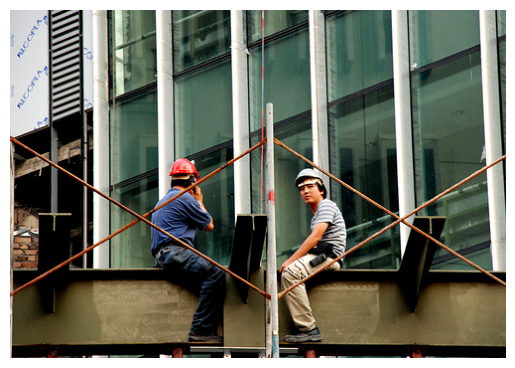

Generated caption: startseq two construction workers workers break endseq


In [23]:
# Load an image
image_id = list(captions_mapping.keys())[40].split('.')[0]  # Get the 45th image id
photo = features[image_id]
photo = np.expand_dims(photo, axis=0)

# Generate caption
caption = generate_caption(lstm_model, tokenizer, photo, max_length)

# Correctly access the image path
image_path = 'flickr8k\\Images\\' + list(captions_mapping.keys())[40]

# Open the image using PIL
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the generated caption
print(f"Generated caption: {caption}")

### **5.2 Evaluating Performance with Metrics**

We evaluate the model's performance using the BLEU score:

- **BLEU Score:** We evaluate the quality of the generated captions by computing BLEU-1 score to compare the generated captions to the reference captions.
- **Interpretation:** As a measure of a higher BLEU score, the generated captions come closer to the reference captions in terms of word overlap.

In [24]:
# Call the function to evaluate the model
evaluate_model(lstm_model, captions_mapping, features, tokenizer, max_length)

BLEU-1: 0.7251
